# MNIST GAN - Hand-written Digit Generation

This notebook implements a Generative Adversarial Network (GAN) using PyTorch to generate hand-written digits from the MNIST dataset.

## Task 2: MNIST Digit Generation GAN

This implementation trains a GAN model on the MNIST dataset to generate realistic hand-written digits (0-9). The trained generator will be integrated into the API for digit generation requests.

## Architecture Specifications

### Generator
- Input: Noise vector of shape (BATCH_SIZE, 100)
- Fully connected layer to 7×7×128, then reshape
- ConvTranspose2D: 128 → 64, kernel size 4, stride 2, padding 1 → output size 14×14
  - Followed by BatchNorm2D and ReLU
- ConvTranspose2D: 64 → 1, kernel size 4, stride 2, padding 1 → output size 28×28
  - Followed by Tanh activation

### Discriminator
- Input: Image of shape (1, 28, 28)
- Conv2D: 1 → 64, kernel size 4, stride 2, padding 1 → output size 14×14
  - Followed by LeakyReLU(0.2)
- Conv2D: 64 → 128, kernel size 4, stride 2, padding 1 → output size 7×7
  - Followed by BatchNorm2D and LeakyReLU(0.2)
- Flatten and apply Linear layer to get a single output (real/fake probability)

## 1. Import Libraries

In [10]:
# Install required packages if needed
# Uncomment and run if packages are missing:
# !pip install torch torchvision matplotlib numpy tqdm torchinfo

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

# Check device
device = torch.device('mps' if torch.backends.mps.is_available() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
print(f'Using device: {device}')

Using device: mps


## 2. Define Generator Network

The Generator takes a noise vector and generates a 28×28 image.

In [12]:
class Generator(nn.Module):
    """
    Generator Network for GAN.
    
    Architecture:
    - Input: Noise vector (batch_size, 100)
    - FC layer: 100 -> 7*7*128
    - Reshape to (batch_size, 128, 7, 7)
    - ConvTranspose2d: 128 -> 64, 14x14
    - ConvTranspose2d: 64 -> 1, 28x28
    """
    
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        
        # Fully connected layer: 100 -> 7*7*128
        self.fc = nn.Linear(noise_dim, 7 * 7 * 128)
        
        # Transpose convolution layers
        self.conv_transpose1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 64 x 14 x 14
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv_transpose2 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 1 x 28 x 28
        
        self.tanh = nn.Tanh()
    
    def forward(self, z):
        """
        Forward pass.
        
        Args:
            z: Noise vector of shape (batch_size, 100)
        
        Returns:
            Generated images of shape (batch_size, 1, 28, 28)
        """
        # FC layer and reshape
        x = self.fc(z)  # (batch_size, 7*7*128)
        x = x.view(-1, 128, 7, 7)  # (batch_size, 128, 7, 7)
        
        # First transpose convolution block
        x = self.conv_transpose1(x)  # (batch_size, 64, 14, 14)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Second transpose convolution block
        x = self.conv_transpose2(x)  # (batch_size, 1, 28, 28)
        x = self.tanh(x)  # Output range: [-1, 1]
        
        return x


# Test the generator
test_gen = Generator(noise_dim=100).to(device)
test_noise = torch.randn(4, 100).to(device)
test_output = test_gen(test_noise)
print(f"Generator output shape: {test_output.shape}")
print(f"Generator output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

# Print model summary
from torchinfo import summary
print("\nGenerator Architecture:")
summary(test_gen, input_size=(4, 100), device=str(device))

Generator output shape: torch.Size([4, 1, 28, 28])
Generator output range: [-1.000, 1.000]

Generator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [4, 1, 28, 28]            --
├─Linear: 1-1                            [4, 6272]                 633,472
├─ConvTranspose2d: 1-2                   [4, 64, 14, 14]           131,136
├─BatchNorm2d: 1-3                       [4, 64, 14, 14]           128
├─ReLU: 1-4                              [4, 64, 14, 14]           --
├─ConvTranspose2d: 1-5                   [4, 1, 28, 28]            1,025
├─Tanh: 1-6                              [4, 1, 28, 28]            --
Total params: 765,761
Trainable params: 765,761
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 108.56
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 3.06
Estimated Total Size (MB): 4.09

## 3. Define Discriminator Network

In [13]:
class Discriminator(nn.Module):
    """
    Discriminator Network for GAN.
    
    Architecture:
    - Input: Images (batch_size, 1, 28, 28)
    - Conv2d: 1 -> 64, 14x14
    - Conv2d: 64 -> 128, 7x7
    - Flatten and FC to single output
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # First convolution layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 64 x 14 x 14
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 128 x 7 x 7
        
        self.bn2 = nn.BatchNorm2d(128)
        
        # Fully connected layer
        self.fc = nn.Linear(128 * 7 * 7, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input images of shape (batch_size, 1, 28, 28)
        
        Returns:
            Predictions of shape (batch_size, 1), range [0, 1]
        """
        # First convolution block
        x = self.conv1(x)  # (batch_size, 64, 14, 14)
        x = self.leaky_relu(x)
        
        # Second convolution block
        x = self.conv2(x)  # (batch_size, 128, 7, 7)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        
        # Flatten and FC layer
        x = x.view(-1, 128 * 7 * 7)  # (batch_size, 128*7*7)
        x = self.fc(x)  # (batch_size, 1)
        x = self.sigmoid(x)
        
        return x


# Test the discriminator
test_disc = Discriminator().to(device)
test_images = torch.randn(4, 1, 28, 28).to(device)
test_pred = test_disc(test_images)
print(f"Discriminator output shape: {test_pred.shape}")
print(f"Discriminator output range: [{test_pred.min():.3f}, {test_pred.max():.3f}]")

# Print model summary
print("\nDiscriminator Architecture:")
summary(test_disc, input_size=(4, 1, 28, 28), device=str(device))

Discriminator output shape: torch.Size([4, 1])
Discriminator output range: [0.333, 0.530]

Discriminator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [4, 1]                    --
├─Conv2d: 1-1                            [4, 64, 14, 14]           1,088
├─LeakyReLU: 1-2                         [4, 64, 14, 14]           --
├─Conv2d: 1-3                            [4, 128, 7, 7]            131,200
├─BatchNorm2d: 1-4                       [4, 128, 7, 7]            256
├─LeakyReLU: 1-5                         [4, 128, 7, 7]            --
├─Linear: 1-6                            [4, 1]                    6,273
├─Sigmoid: 1-7                           [4, 1]                    --
Total params: 138,817
Trainable params: 138,817
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 26.59
Input size (MB): 0.01
Forward/backward pass size (MB): 0.80
Params size (MB): 0.56
Estimated Total Size (MB): 1.37

## 4. Load and Prepare Data

Dataset: MNIST (Hand-written Digits)
Number of training samples: 60000
Number of batches: 469
Image shape: torch.Size([1, 28, 28])


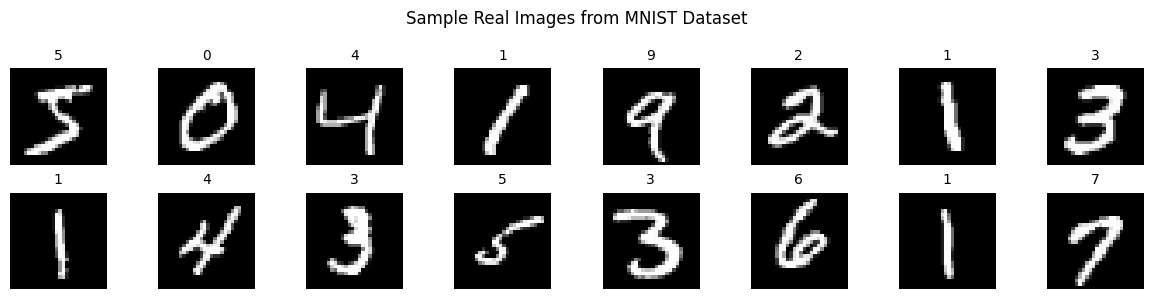

In [14]:
# Hyperparameters
batch_size = 128
noise_dim = 100
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5

# Data transformation: normalize to [-1, 1] to match Generator's tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset (hand-written digits)
train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print(f"Dataset: MNIST (Hand-written Digits)")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# Visualize some real images
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Denormalize for display
    img = img * 0.5 + 0.5
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'{label}', fontsize=10)
    ax.axis('off')
plt.suptitle("Sample Real Images from MNIST Dataset")
plt.tight_layout()
plt.show()

## 5. Initialize Models and Optimizers

In [15]:
# Initialize Generator and Discriminator
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function: Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizers (using Adam with beta1=0.5 as recommended for GANs)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

print("Models initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Device: {device}")

Models initialized successfully!
Generator parameters: 765,761
Discriminator parameters: 138,817
Device: mps


## 6. Training Loop

Starting training...


Epoch 1/50: 100%|██████████| 469/469 [00:12<00:00, 37.28it/s, D_loss=0.2887, G_loss=2.1232]


Epoch [1/50] - D_loss: 0.3288, G_loss: 2.4936


Epoch 2/50: 100%|██████████| 469/469 [00:09<00:00, 47.82it/s, D_loss=0.1815, G_loss=2.9003]


Epoch [2/50] - D_loss: 0.3232, G_loss: 2.5176


Epoch 3/50: 100%|██████████| 469/469 [00:09<00:00, 47.20it/s, D_loss=0.2897, G_loss=2.1492]


Epoch [3/50] - D_loss: 0.3082, G_loss: 2.6429


Epoch 4/50: 100%|██████████| 469/469 [00:09<00:00, 47.64it/s, D_loss=0.4472, G_loss=1.2457]


Epoch [4/50] - D_loss: 0.3255, G_loss: 2.6096


Epoch 5/50: 100%|██████████| 469/469 [00:09<00:00, 47.87it/s, D_loss=0.3089, G_loss=2.7470]



Epoch [5/50] - D_loss: 0.3730, G_loss: 2.5255


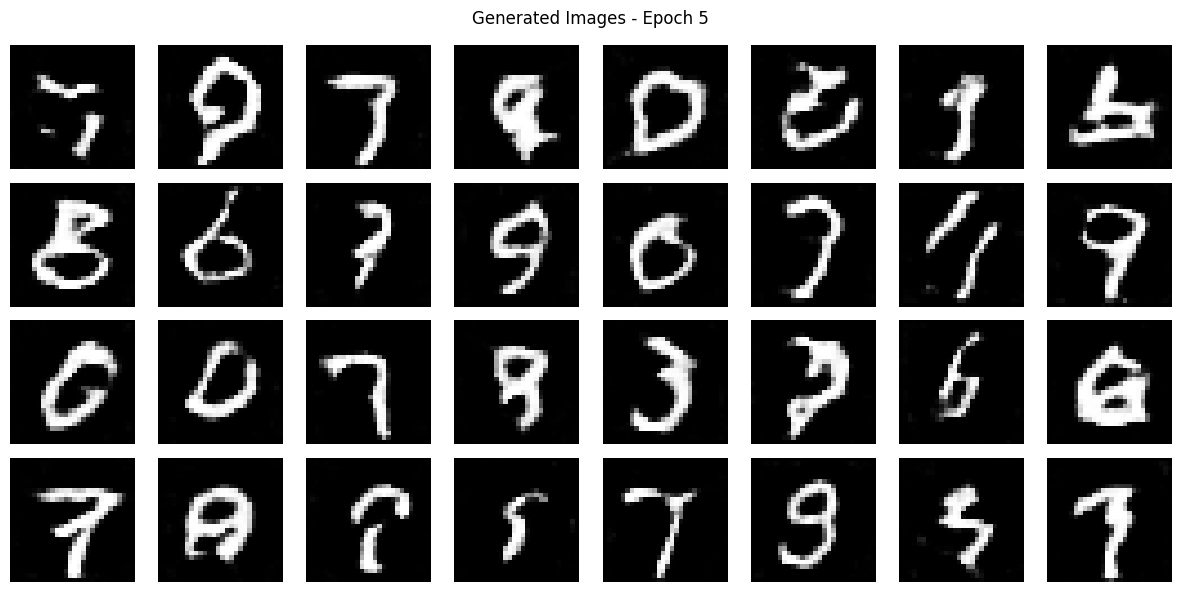

Epoch 6/50: 100%|██████████| 469/469 [00:10<00:00, 46.62it/s, D_loss=0.2345, G_loss=2.8792]


Epoch [6/50] - D_loss: 0.3774, G_loss: 2.5139


Epoch 7/50: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s, D_loss=1.0779, G_loss=2.0085]


Epoch [7/50] - D_loss: 0.4010, G_loss: 2.5255


Epoch 8/50: 100%|██████████| 469/469 [00:09<00:00, 47.48it/s, D_loss=0.3827, G_loss=2.7902]


Epoch [8/50] - D_loss: 0.3757, G_loss: 2.5451


Epoch 9/50: 100%|██████████| 469/469 [00:09<00:00, 47.86it/s, D_loss=0.3912, G_loss=2.2520]


Epoch [9/50] - D_loss: 0.3871, G_loss: 2.6113


Epoch 10/50: 100%|██████████| 469/469 [00:09<00:00, 47.56it/s, D_loss=0.2976, G_loss=2.5038]

Epoch [10/50] - D_loss: 0.3539, G_loss: 2.6790


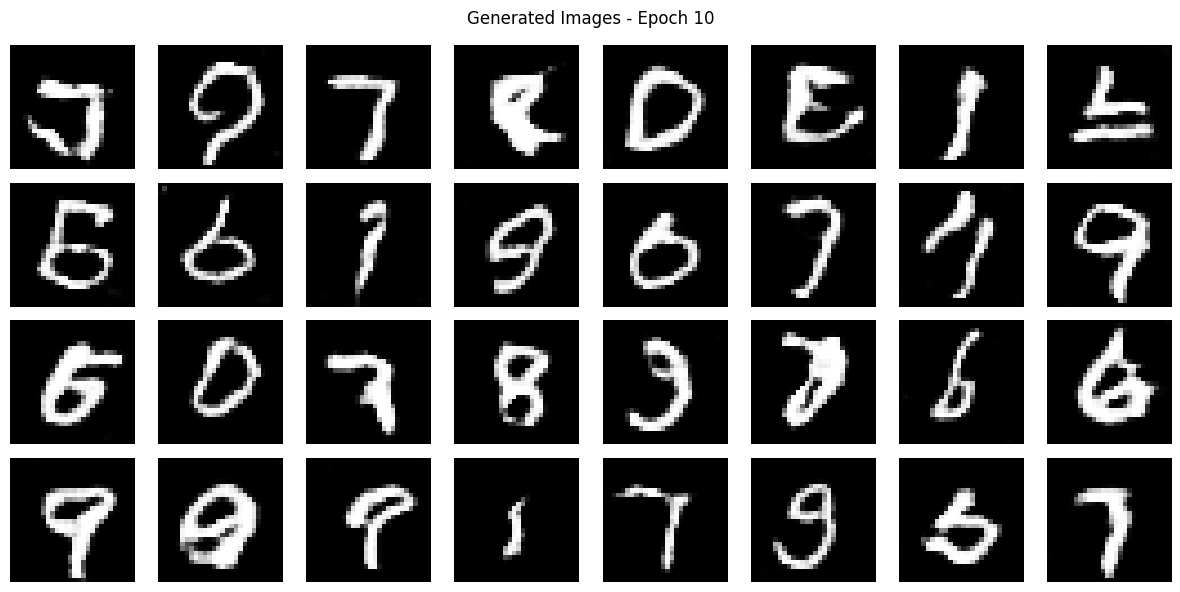

Epoch 11/50: 100%|██████████| 469/469 [00:09<00:00, 47.38it/s, D_loss=0.3504, G_loss=2.9294]


Epoch [11/50] - D_loss: 0.3545, G_loss: 2.7558


Epoch 12/50: 100%|██████████| 469/469 [00:09<00:00, 47.80it/s, D_loss=0.2629, G_loss=2.4204]


Epoch [12/50] - D_loss: 0.3368, G_loss: 2.8165


Epoch 13/50: 100%|██████████| 469/469 [00:09<00:00, 47.85it/s, D_loss=0.5035, G_loss=3.9653]


Epoch [13/50] - D_loss: 0.3435, G_loss: 2.8710


Epoch 14/50: 100%|██████████| 469/469 [00:09<00:00, 47.99it/s, D_loss=0.3225, G_loss=2.5092]


Epoch [14/50] - D_loss: 0.3135, G_loss: 2.9606


Epoch 15/50: 100%|██████████| 469/469 [00:09<00:00, 47.59it/s, D_loss=0.2209, G_loss=2.4792]

Epoch [15/50] - D_loss: 0.3372, G_loss: 2.9406


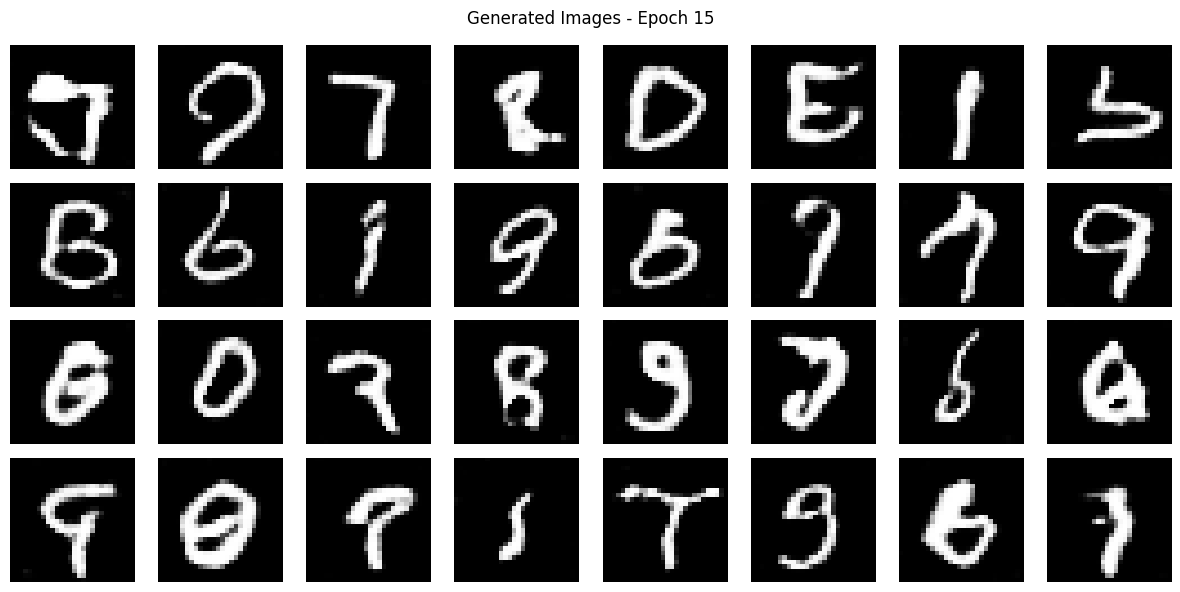

Epoch 16/50: 100%|██████████| 469/469 [00:09<00:00, 47.92it/s, D_loss=0.2877, G_loss=3.2741]


Epoch [16/50] - D_loss: 0.2949, G_loss: 3.0793


Epoch 17/50: 100%|██████████| 469/469 [00:09<00:00, 47.97it/s, D_loss=0.2058, G_loss=3.1130]


Epoch [17/50] - D_loss: 0.2921, G_loss: 3.1312


Epoch 18/50: 100%|██████████| 469/469 [00:09<00:00, 47.99it/s, D_loss=0.3293, G_loss=4.1676]


Epoch [18/50] - D_loss: 0.3135, G_loss: 3.1206


Epoch 19/50: 100%|██████████| 469/469 [00:09<00:00, 47.53it/s, D_loss=0.2702, G_loss=2.5701]


Epoch [19/50] - D_loss: 0.2857, G_loss: 3.2169


Epoch 20/50: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s, D_loss=0.1485, G_loss=3.3607]

Epoch [20/50] - D_loss: 0.2699, G_loss: 3.2764


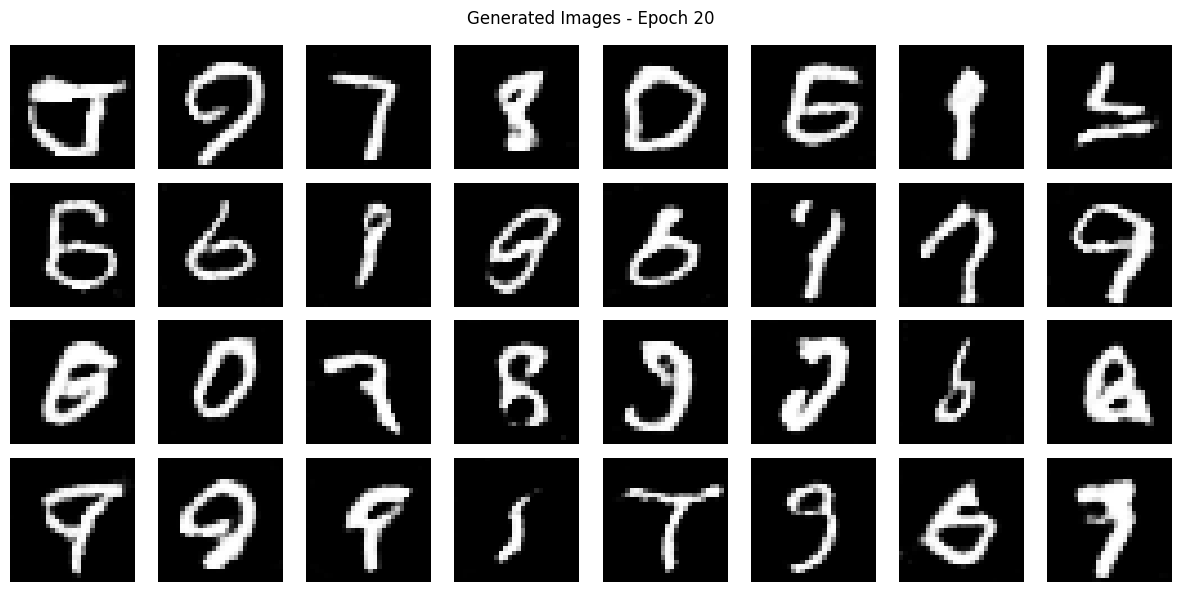

Epoch 21/50: 100%|██████████| 469/469 [00:09<00:00, 47.55it/s, D_loss=0.2447, G_loss=3.8611]


Epoch [21/50] - D_loss: 0.2907, G_loss: 3.2792


Epoch 22/50: 100%|██████████| 469/469 [00:09<00:00, 47.39it/s, D_loss=0.4583, G_loss=5.4398]


Epoch [22/50] - D_loss: 0.3050, G_loss: 3.2436


Epoch 23/50: 100%|██████████| 469/469 [00:09<00:00, 47.84it/s, D_loss=0.1957, G_loss=2.8384]


Epoch [23/50] - D_loss: 0.2801, G_loss: 3.3473


Epoch 24/50: 100%|██████████| 469/469 [00:09<00:00, 47.62it/s, D_loss=0.2110, G_loss=3.2696]


Epoch [24/50] - D_loss: 0.3026, G_loss: 3.3253


Epoch 25/50: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s, D_loss=0.4145, G_loss=1.0397]

Epoch [25/50] - D_loss: 0.2487, G_loss: 3.4725


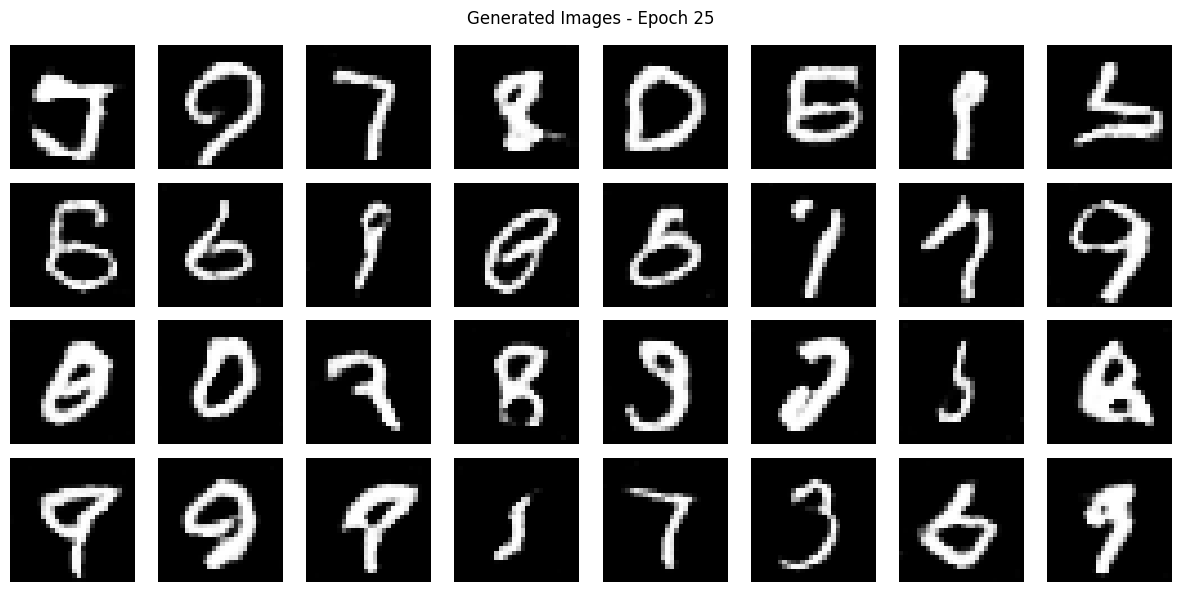

Epoch 26/50: 100%|██████████| 469/469 [00:09<00:00, 47.61it/s, D_loss=0.1961, G_loss=3.4778]


Epoch [26/50] - D_loss: 0.3269, G_loss: 3.3710


Epoch 27/50: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s, D_loss=0.1524, G_loss=3.6026]


Epoch [27/50] - D_loss: 0.2538, G_loss: 3.4551


Epoch 28/50: 100%|██████████| 469/469 [00:09<00:00, 47.73it/s, D_loss=0.2828, G_loss=2.8087]


Epoch [28/50] - D_loss: 0.2874, G_loss: 3.4177


Epoch 29/50: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s, D_loss=0.1686, G_loss=3.7223]


Epoch [29/50] - D_loss: 0.2504, G_loss: 3.5209


Epoch 30/50: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s, D_loss=0.1873, G_loss=3.2014]



Epoch [30/50] - D_loss: 0.2366, G_loss: 3.6383


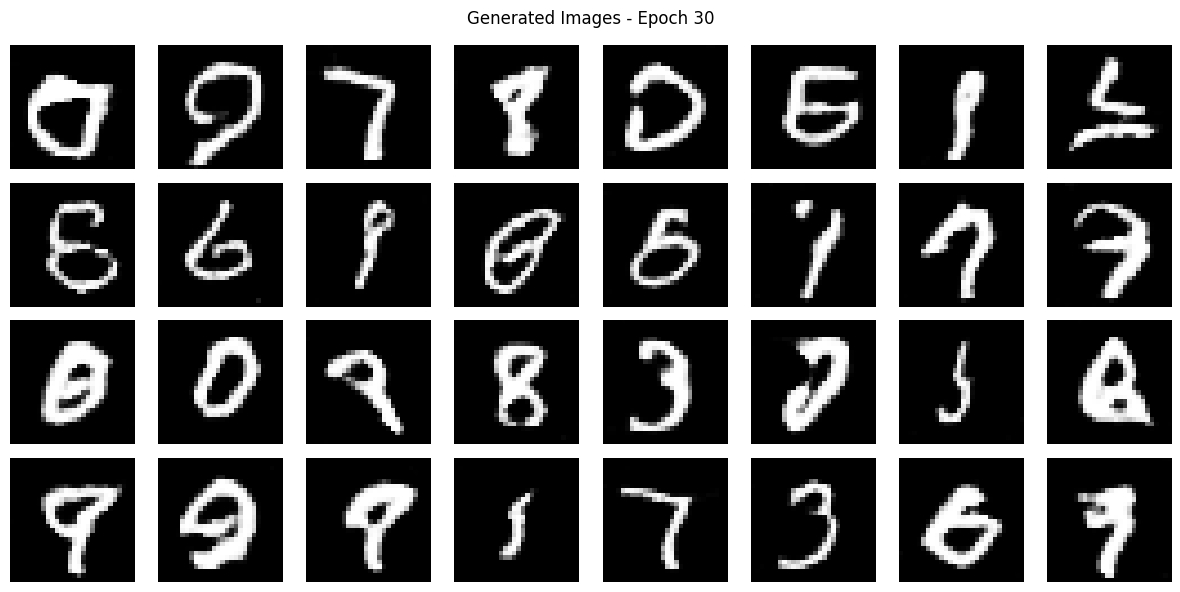

Epoch 31/50: 100%|██████████| 469/469 [00:09<00:00, 47.56it/s, D_loss=0.3311, G_loss=3.1708]


Epoch [31/50] - D_loss: 0.2748, G_loss: 3.6783


Epoch 32/50: 100%|██████████| 469/469 [00:09<00:00, 47.84it/s, D_loss=0.3144, G_loss=4.6762]


Epoch [32/50] - D_loss: 0.2687, G_loss: 3.4870


Epoch 33/50: 100%|██████████| 469/469 [00:09<00:00, 47.73it/s, D_loss=0.2208, G_loss=3.1901]


Epoch [33/50] - D_loss: 0.2632, G_loss: 3.5519


Epoch 34/50: 100%|██████████| 469/469 [00:09<00:00, 47.85it/s, D_loss=0.2390, G_loss=3.8872]


Epoch [34/50] - D_loss: 0.2315, G_loss: 3.6870


Epoch 35/50: 100%|██████████| 469/469 [00:09<00:00, 47.76it/s, D_loss=0.2733, G_loss=4.2129] 

Epoch [35/50] - D_loss: 0.2952, G_loss: 3.6605


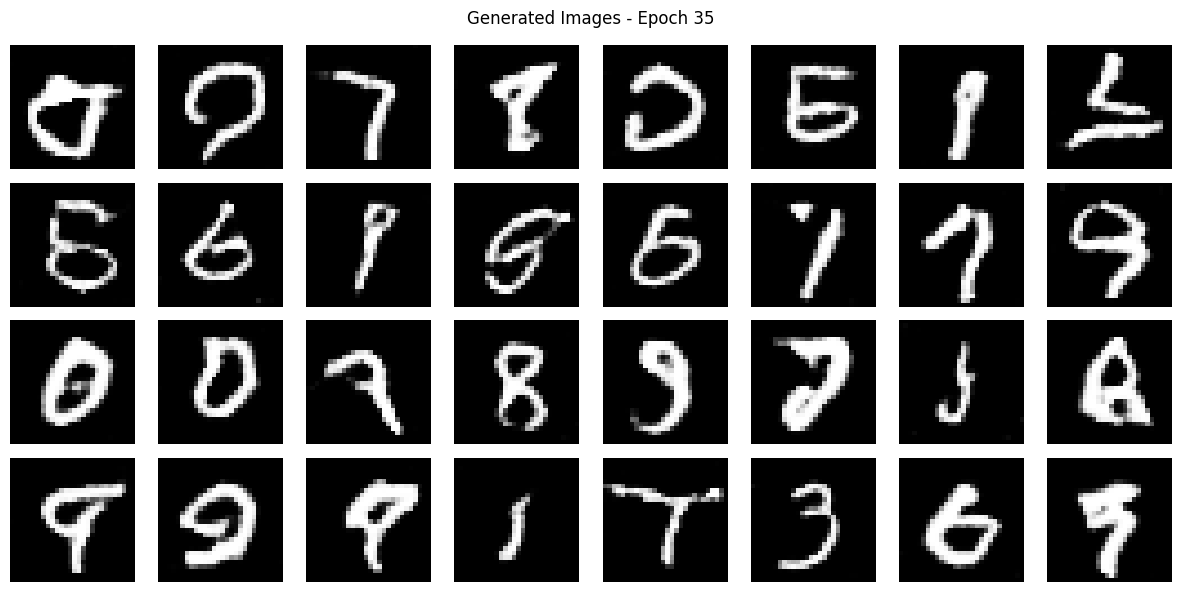

Epoch 36/50: 100%|██████████| 469/469 [00:09<00:00, 47.81it/s, D_loss=0.2561, G_loss=2.8570]


Epoch [36/50] - D_loss: 0.2219, G_loss: 3.6892


Epoch 37/50: 100%|██████████| 469/469 [00:09<00:00, 47.77it/s, D_loss=0.1090, G_loss=3.8917]


Epoch [37/50] - D_loss: 0.2158, G_loss: 3.8131


Epoch 38/50: 100%|██████████| 469/469 [00:09<00:00, 47.72it/s, D_loss=0.2255, G_loss=3.5222]


Epoch [38/50] - D_loss: 0.2904, G_loss: 3.7030


Epoch 39/50: 100%|██████████| 469/469 [00:09<00:00, 47.65it/s, D_loss=0.1636, G_loss=3.9943]


Epoch [39/50] - D_loss: 0.2087, G_loss: 3.8647


Epoch 40/50: 100%|██████████| 469/469 [00:09<00:00, 48.17it/s, D_loss=0.1695, G_loss=3.3542]

Epoch [40/50] - D_loss: 0.2119, G_loss: 3.9280


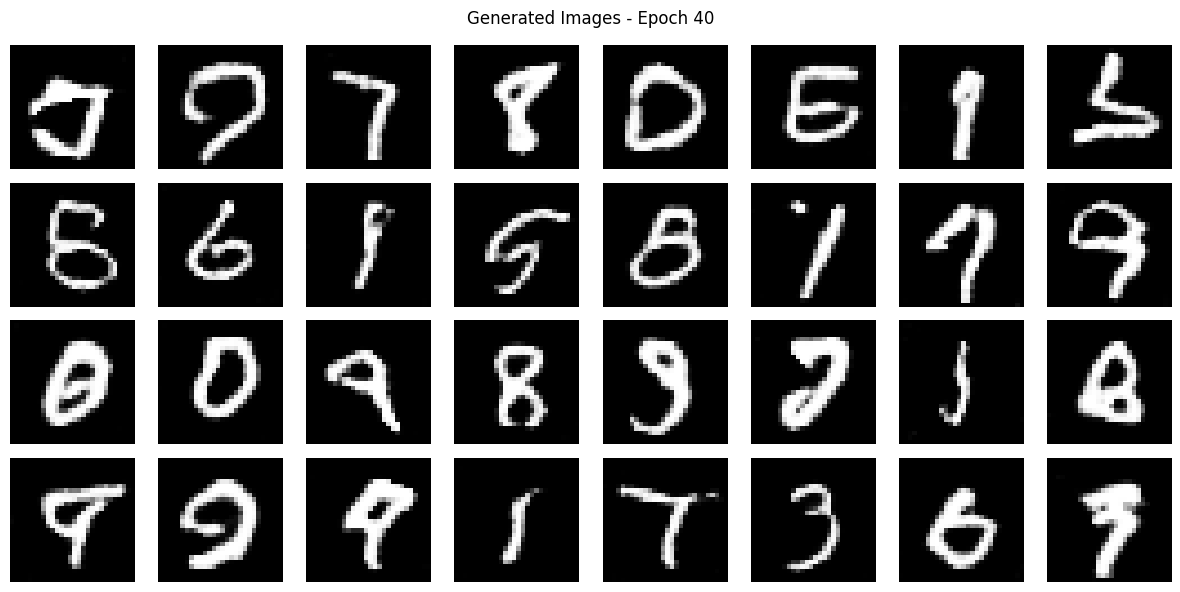

Epoch 41/50: 100%|██████████| 469/469 [00:09<00:00, 47.59it/s, D_loss=0.1080, G_loss=4.4327]


Epoch [41/50] - D_loss: 0.2131, G_loss: 3.9713


Epoch 42/50: 100%|██████████| 469/469 [00:09<00:00, 48.07it/s, D_loss=0.2068, G_loss=3.2807]


Epoch [42/50] - D_loss: 0.2796, G_loss: 3.7641


Epoch 43/50: 100%|██████████| 469/469 [00:09<00:00, 48.11it/s, D_loss=0.2162, G_loss=4.5119]


Epoch [43/50] - D_loss: 0.2045, G_loss: 3.9718


Epoch 44/50: 100%|██████████| 469/469 [00:10<00:00, 46.88it/s, D_loss=0.1381, G_loss=3.8542]


Epoch [44/50] - D_loss: 0.2349, G_loss: 3.9557


Epoch 45/50: 100%|██████████| 469/469 [00:09<00:00, 47.26it/s, D_loss=0.2035, G_loss=4.1292] 

Epoch [45/50] - D_loss: 0.2607, G_loss: 3.8754


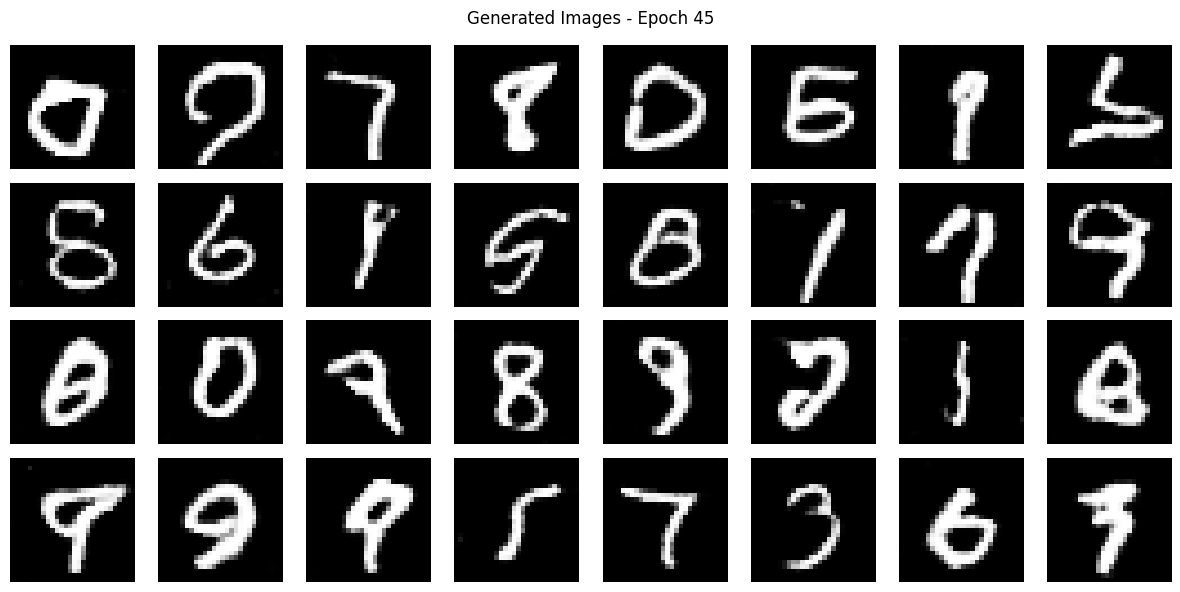

Epoch 46/50: 100%|██████████| 469/469 [00:09<00:00, 47.60it/s, D_loss=0.2258, G_loss=3.5139]


Epoch [46/50] - D_loss: 0.1910, G_loss: 4.0552


Epoch 47/50: 100%|██████████| 469/469 [00:09<00:00, 47.65it/s, D_loss=0.1314, G_loss=4.5548]


Epoch [47/50] - D_loss: 0.1900, G_loss: 4.1464


Epoch 48/50: 100%|██████████| 469/469 [00:09<00:00, 47.83it/s, D_loss=0.1961, G_loss=5.4598]


Epoch [48/50] - D_loss: 0.1832, G_loss: 4.1815


Epoch 49/50: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s, D_loss=0.1941, G_loss=3.4207]


Epoch [49/50] - D_loss: 0.2830, G_loss: 3.9773


Epoch 50/50: 100%|██████████| 469/469 [00:09<00:00, 47.84it/s, D_loss=0.2179, G_loss=2.6783]

Epoch [50/50] - D_loss: 0.1900, G_loss: 4.1545


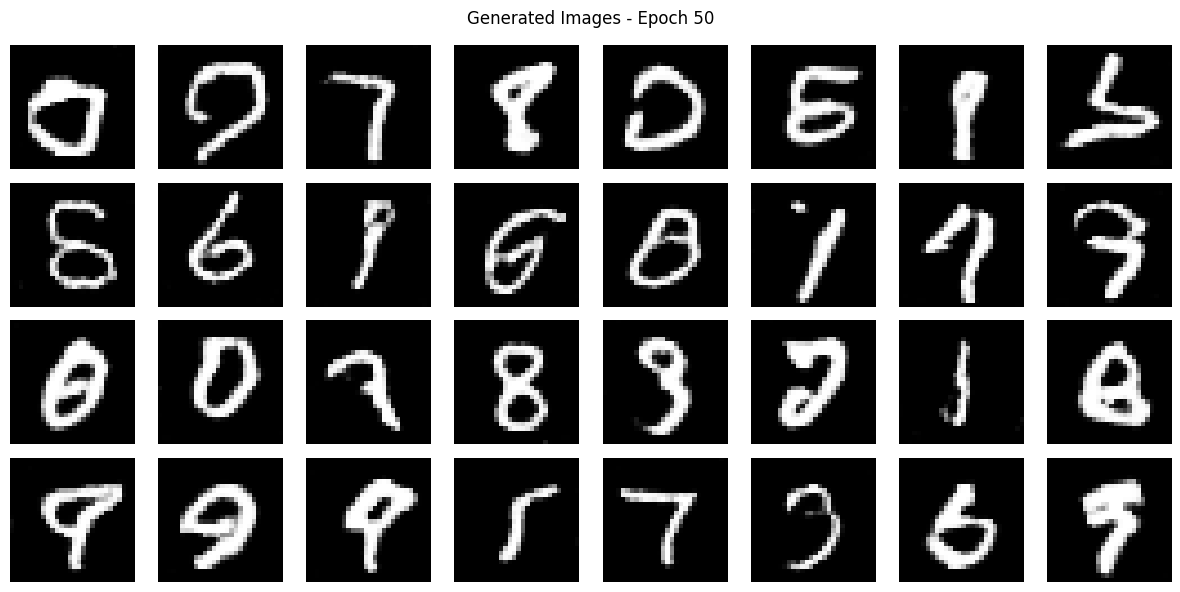

Training completed!


In [16]:
# Lists to store losses for plotting
g_losses = []
d_losses = []

# Fixed noise for visualization
fixed_noise = torch.randn(64, noise_dim).to(device)

print("Starting training...")

for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (real_images, _) in enumerate(pbar):
        batch_size_actual = real_images.size(0)
        real_images = real_images.to(device)
        
        # Create labels
        real_labels = torch.full((batch_size_actual, 1), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size_actual, 1), fake_label, dtype=torch.float, device=device)
        
        # ========================================
        # Train Discriminator
        # ========================================
        optimizer_d.zero_grad()
        
        # Train on real images
        output_real = discriminator(real_images)
        loss_d_real = criterion(output_real, real_labels)
        
        # Train on fake images
        noise = torch.randn(batch_size_actual, noise_dim).to(device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())  # Detach to avoid training G
        loss_d_fake = criterion(output_fake, fake_labels)
        
        # Total discriminator loss
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()
        
        # ========================================
        # Train Generator
        # ========================================
        optimizer_g.zero_grad()
        
        # Generate fake images and get discriminator's opinion
        output_fake_for_g = discriminator(fake_images)
        loss_g = criterion(output_fake_for_g, real_labels)  # Generator wants D to think they're real
        
        loss_g.backward()
        optimizer_g.step()
        
        # Track losses
        epoch_g_loss += loss_g.item()
        epoch_d_loss += loss_d.item()
        
        # Update progress bar
        pbar.set_postfix({
            'D_loss': f'{loss_d.item():.4f}',
            'G_loss': f'{loss_g.item():.4f}'
        })
    
    # Average losses for the epoch
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss = epoch_d_loss / len(train_loader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}")
    
    # Generate and display sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
            # Denormalize
            fake_samples = fake_samples * 0.5 + 0.5
            
            # Plot
            fig, axes = plt.subplots(4, 8, figsize=(12, 6))
            for idx, ax in enumerate(axes.flat):
                if idx < len(fake_samples):
                    ax.imshow(fake_samples[idx].squeeze(), cmap='gray')
                ax.axis('off')
            plt.suptitle(f"Generated Images - Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()
        generator.train()

print("Training completed!")

## 7. Visualize Training Progress

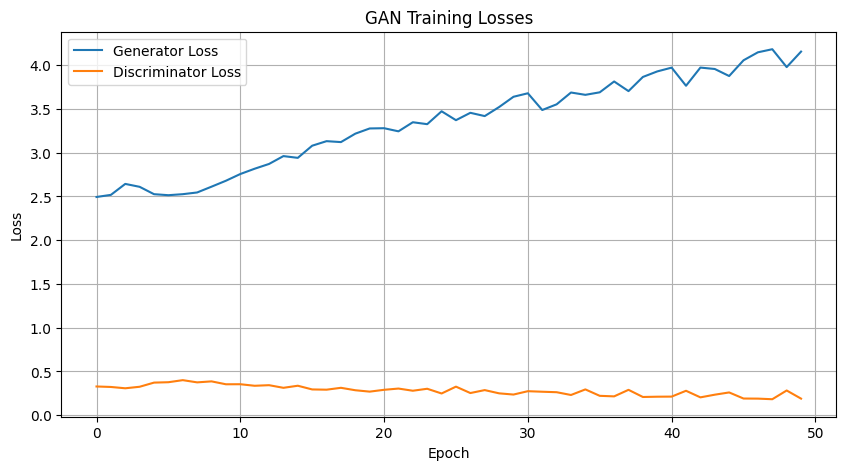

Final Generator Loss: 4.1545
Final Discriminator Loss: 0.1900
Average Generator Loss: 3.3404
Average Discriminator Loss: 0.2838


In [17]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

# Show loss statistics
print(f"Final Generator Loss: {g_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
print(f"Average Generator Loss: {np.mean(g_losses):.4f}")
print(f"Average Discriminator Loss: {np.mean(d_losses):.4f}")

## 8. Generate New Hand-written Digits

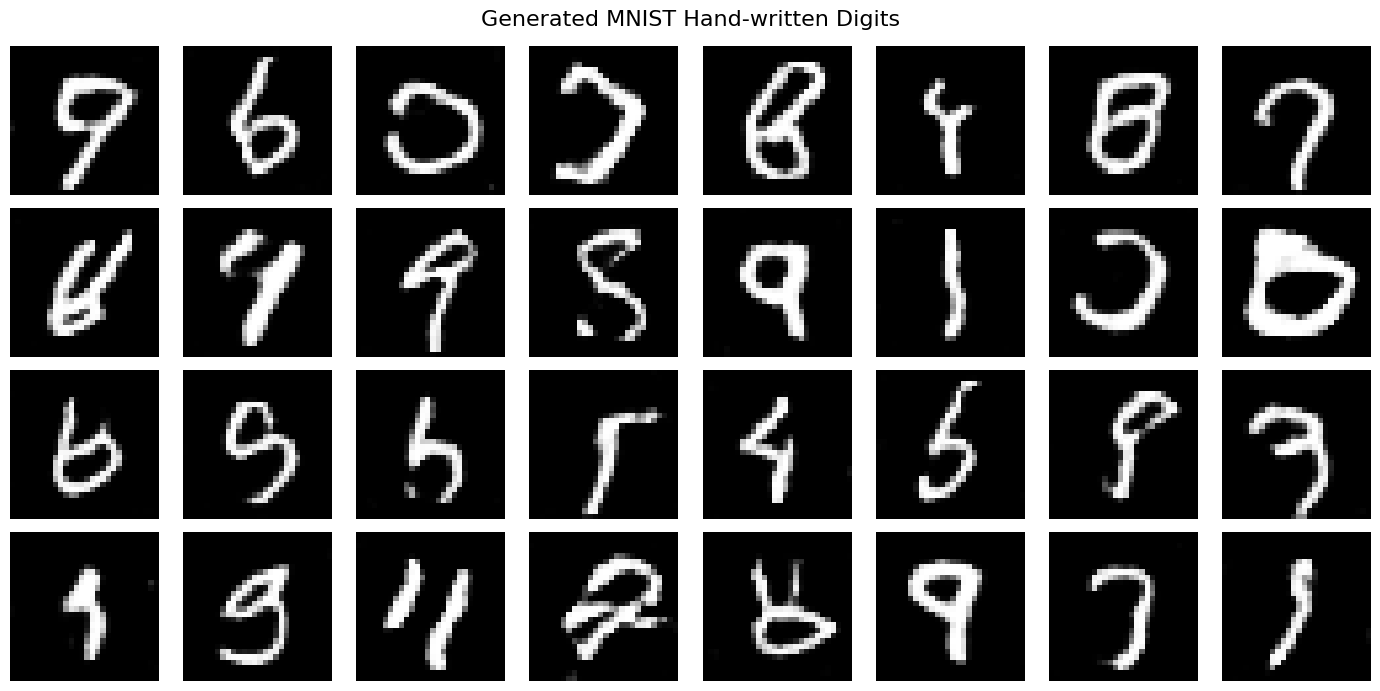

In [18]:
# Generate new images with the trained generator
generator.eval()

num_samples = 32
with torch.no_grad():
    # Generate random noise
    noise = torch.randn(num_samples, noise_dim).to(device)
    
    # Generate fake images
    generated_images = generator(noise).cpu()
    
    # Denormalize to [0, 1] range
    generated_images = generated_images * 0.5 + 0.5

# Display generated images
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    ax.imshow(generated_images[idx].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated MNIST Hand-written Digits", fontsize=16)
plt.tight_layout()
plt.show()

## 9. Compare Real vs Generated Images

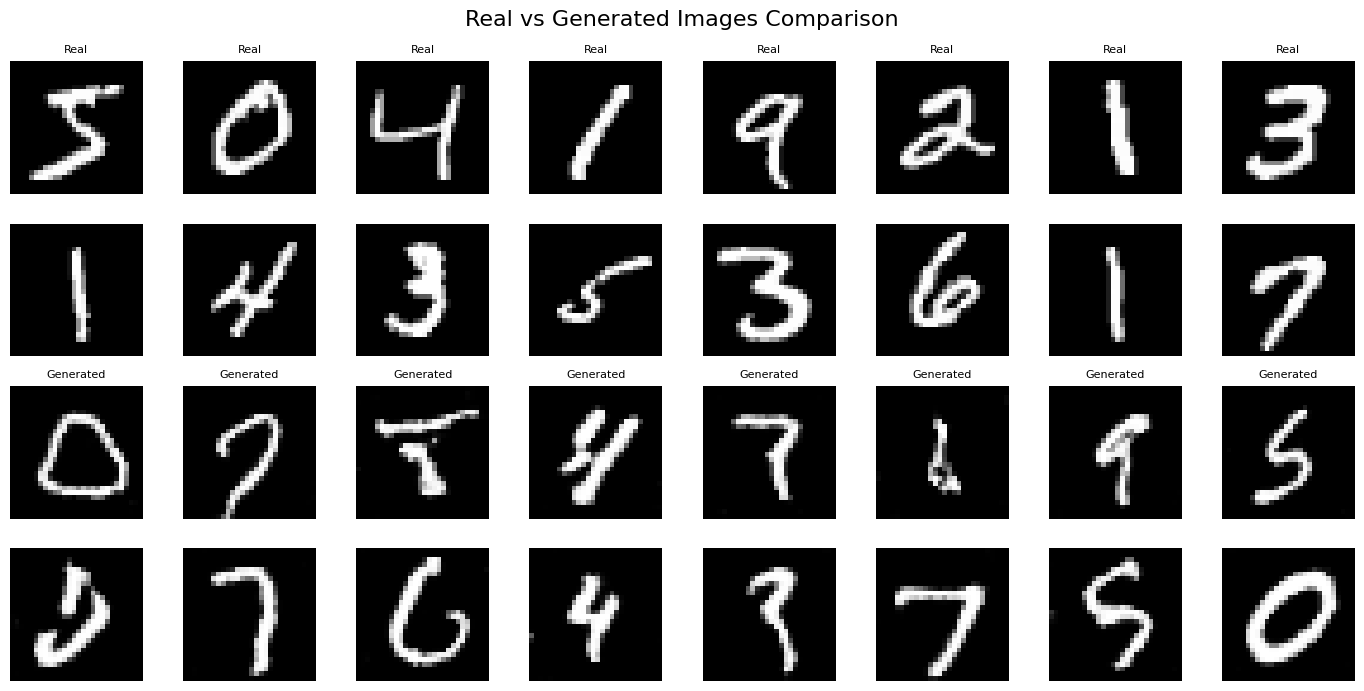

In [19]:
# Compare real and generated images side by side
fig, axes = plt.subplots(4, 8, figsize=(14, 7))

# Get some real images
real_images_list = []
for i in range(16):
    img, _ = train_dataset[i]
    # Denormalize
    img = img * 0.5 + 0.5
    real_images_list.append(img.squeeze().numpy())

# Generate fake images
with torch.no_grad():
    noise = torch.randn(16, noise_dim).to(device)
    fake_images = generator(noise).cpu()
    fake_images = fake_images * 0.5 + 0.5

fake_images_list = [img.squeeze().numpy() for img in fake_images]

# Plot real and fake images
for idx in range(16):
    # Real images in first two rows
    row = idx // 8
    col = idx % 8
    axes[row, col].imshow(real_images_list[idx], cmap='gray')
    axes[row, col].axis('off')
    if idx < 8:
        axes[row, col].set_title('Real', fontsize=8)
    
    # Fake images in last two rows
    row = idx // 8 + 2
    axes[row, col].imshow(fake_images_list[idx], cmap='gray')
    axes[row, col].axis('off')
    if idx < 8:
        axes[row, col].set_title('Generated', fontsize=8)

plt.suptitle("Real vs Generated Images Comparison", fontsize=16)
plt.tight_layout()
plt.show()

## 10. Save Models

In [20]:
# Save the trained models
import os

# Create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save generator
torch.save({
    'epoch': num_epochs,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_g.state_dict(),
    'g_losses': g_losses,
}, '../models/generator_gan.pth')

# Save discriminator
torch.save({
    'epoch': num_epochs,
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_d.state_dict(),
    'd_losses': d_losses,
}, '../models/discriminator_gan.pth')

print("Models saved successfully!")
print("- Generator saved to: ../models/generator_gan.pth")
print("- Discriminator saved to: ../models/discriminator_gan.pth")

Models saved successfully!
- Generator saved to: ../models/generator_gan.pth
- Discriminator saved to: ../models/discriminator_gan.pth
